In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path

import matplotlib.pyplot as plt
import numpy as np
from PAOFLOW import PAOFLOW

### PW to LCAO

In [2]:
paoflow = PAOFLOW.PAOFLOW(savedir='/home/anooja/Desktop/los-dmrg/tests/benzene/qe/out/aiida.save', model=None, outputdir='/home/anooja/Desktop/los-dmrg/tests/benzene/paoflow', smearing='gauss',verbose=True)
data_controller = paoflow.data_controller
arry,attr = paoflow.data_controller.data_dicts()


#############################################################################################
#                                                                                           #
#                                          PAOFLOW                                          #
#                                                                                           #
#                  Utility to construct and operate on Hamiltonians from                    #
#                 the Projections of DFT wfc on Atomic Orbital bases (PAO)                  #
#                                                                                           #
#                       (c)2016-2024 ERMES group (http://ermes.unt.edu)                     #
#############################################################################################

Monkhorst and Pack grid: 1 1 1 0 0 0
Insulator: True
Magnetic: False
Number of kpoints: 1
Number of electrons: 30.000000
Number of bands: 19
SciPy will 

[anooja-ThinkPad-X1-Carbon-Gen-11:29375] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [3]:
paoflow.projections()

atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [15.86166997 13.22809756  9.44863054]
      atwfc:   1  2S  l=0, m=1
      atwfc:   2  2P  l=1, m=1
      atwfc:   3  2P  l=1, m=2
      atwfc:   4  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [14.54487656 15.50888255  9.44863054]
      atwfc:   5  2S  l=0, m=1
      atwfc:   6  2P  l=1, m=1
      atwfc:   7  2P  l=1, m=2
      atwfc:   8  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [11.91126374 15.50889673  9.44863054]
      atwfc:   9  2S  l=0, m=1
      atwfc:  10  2P  l=1, m=1
      atwfc:  11  2P  l=1, m=2
      atwfc:  12  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [10.59446244 13.22809256  9.44863054]
      atwfc:  13  2S  l=0, m=1
      atwfc:  14  2P  l=1, m=1
      atwfc:  15  2P  l=1, m=2
      atwfc:  16  2P  l=1, m=3
atom: C   pseudo: C.pbesol-n-kjpaw_psl.1.0.0.UPF  tau: [11.91127087 10.94731076  9.44863054]
      atwfc:  17  2S  l=0, m=1
      at

In [4]:
# build the paoflow bands
paoflow.projectability(pthr=0.9)

Projectability vector  [0.98347373 0.98517242 0.98541747 0.97826427 0.9782644  0.96589947
 0.98663559 0.98382099 0.9801185  0.97944899 0.97723149 0.99241522
 0.99241558 0.99714987 0.99714986 0.94158916 0.94174299 0.26615988
 0.17966681]
# of bands with good projectability > 0.9 = 17
Range of suggested shift  4.4257121885227875  ,  4.4257121885227875
Projectability in:                          0.007 sec


In [5]:
paoflow.read_atomic_proj_QE()

In [6]:
Sk = arry["Sks"][:,:,0].real


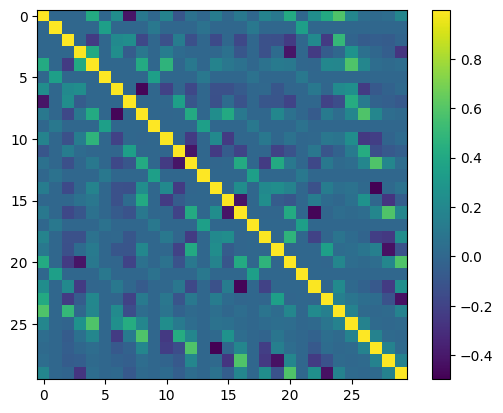

In [7]:
plt.imshow(Sk)
plt.colorbar()

In [8]:
paoflow.pao_hamiltonian()
# arry["HRs"] has dimensions (nawf,nawf,nk1,nk2,nk3,nspin)
HR = arry["HRs"][:,:,0,0,0,0]


Building Hks in:                            0.268 sec
k -> R in:                                  0.003 sec


In [9]:
SR = arry["SRs"][:,:,0]

Bands in:                                   0.224 sec


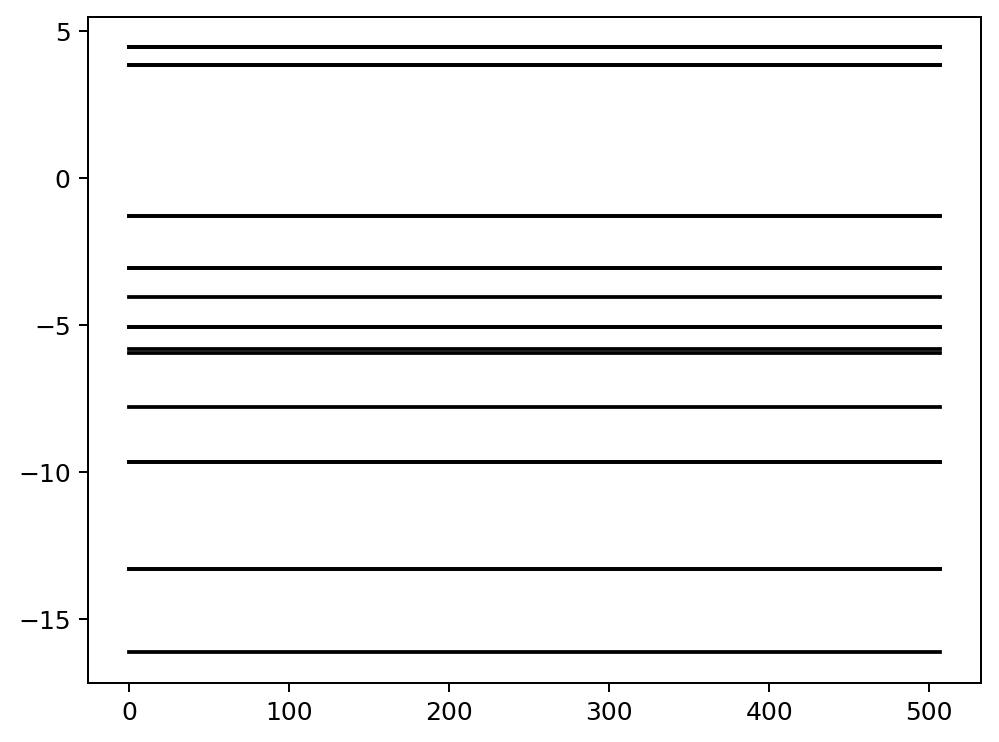

In [10]:
paoflow.bands(ibrav=2, nk=500)
fig = plt.figure(dpi=180)
# plot the paoflow bands
eband = arry['E_k']
for ib in range(eband.shape[1]):
    plt.plot(eband[:,ib],color='black')
# plt.ylim(-3,1)
plt.show()

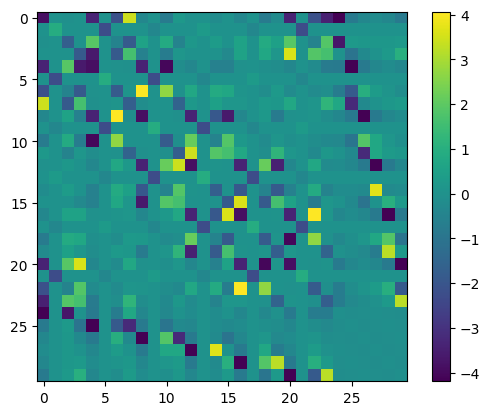

In [11]:
plt.imshow(HR.real)
plt.colorbar()

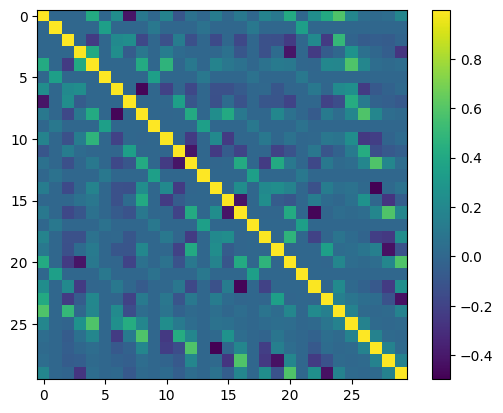

In [12]:
plt.imshow(SR.real)
plt.colorbar()

### LCAO to LOs

In [13]:
import numpy as np
from ase import *
from gpaw import *
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms
from ase.io import read


In [16]:
nao = [list(item.values())[0] for item in arry['nao']]


In [17]:
H_lcao = HR
S_lcao = SR

In [18]:
H_lcao.shape

(30, 30)

In [19]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

In [20]:
atoms = read('./struct.xyz')
basis = Basis(atoms, nao)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)


In [21]:
def plot_hamiltonian_overlap(H, S, cmap, norm, title_H="H Matrix", title_S="S Matrix"):
    """
    Plot the Hamiltonian and Overlap matrices with a shared colorbar and customized color mapping.

    Parameters:
    - H: np.ndarray, Hamiltonian matrix to visualize.
    - S: np.ndarray, Overlap matrix to visualize.
    - cmap: Colormap, the colormap for the plot.
    - norm: Normalization, the normalization for color mapping.
    - title_H: str, Title for the Hamiltonian plot.
    - title_S: str, Title for the Overlap plot.

    Returns:
    - None, displays the plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot H matrix
    cax1 = axs[0].imshow(np.abs(H), interpolation='nearest', cmap=cmap, norm=norm)
    axs[0].set_title(title_H)

    # Plot S matrix
    cax2 = axs[1].imshow(np.abs(S), interpolation='nearest', cmap=cmap, norm=norm)
    axs[1].set_title(title_S)

    # Add a single colorbar shared by both subplots
    cbar = fig.colorbar(cax2, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Energy (eV)')

    # plt.tight_layout()
    plt.show()

In [22]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

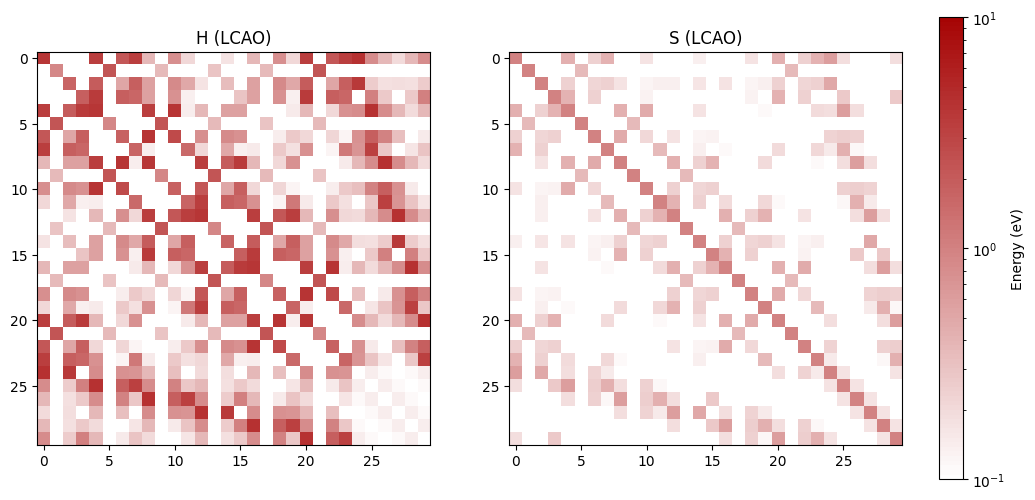

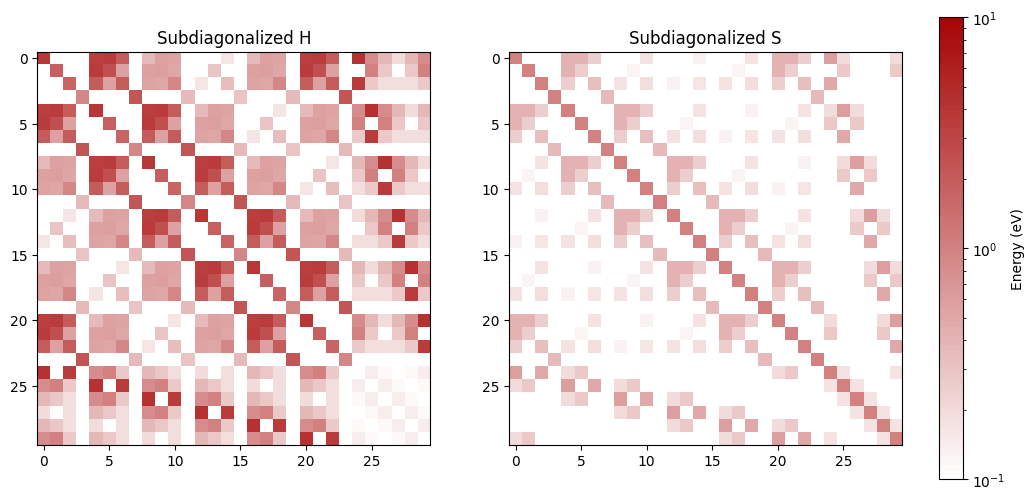

In [23]:
# Plot LCAO matrices
plot_hamiltonian_overlap(H_lcao, S_lcao, title_H="H (LCAO)", title_S="S (LCAO)", cmap=cmap, norm=norm)

# Plot subdiagonalized matrices
plot_hamiltonian_overlap(H_subdiagonal, S_subdiagonal, title_H="Subdiagonalized H", title_S="Subdiagonalized S", cmap=cmap, norm=norm)


In [24]:

def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


In [25]:
# Define the active region within the subdiagonalized species (C 2 pz in this case)
active = {'C':[3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]


for idx in index_active_region:
    if Usub[idx-1,idx] < 0.: # change sign
        Usub[:,idx] *= -1

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

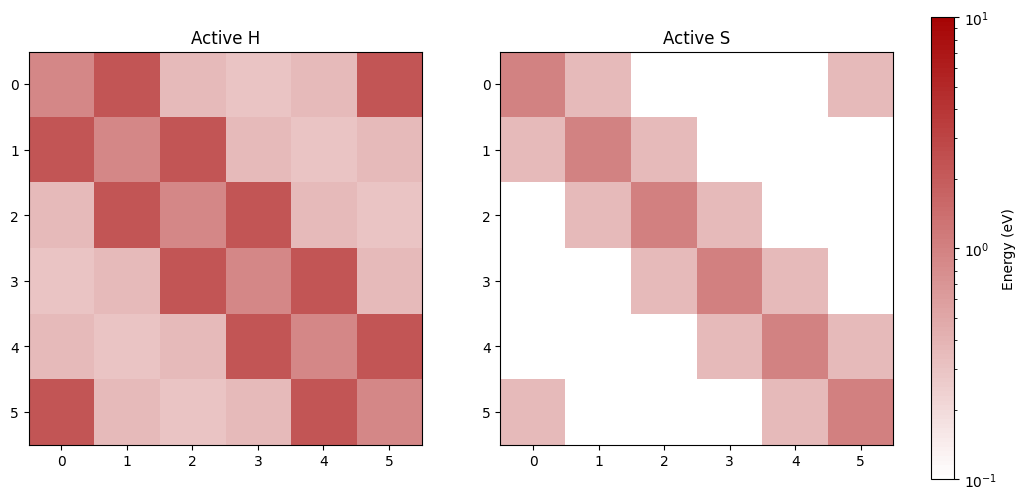

In [26]:
plot_hamiltonian_overlap(H_active, S_active, title_H="Active H", title_S="Active S", cmap=cmap, norm=norm)

In [27]:
def print_largest_non_diagonal_elements(S, n=3):
    """
    Prints the n largest non-diagonal absolute values from an overlap matrix.

    Parameters:
    - S: np.ndarray, the overlap matrix.
    - n: int, the number of largest non-diagonal elements to print.

    Returns:
    - None, prints the largest values and their indices.
    """
    # Ensure the input matrix is square
    assert S.shape[0] == S.shape[1], "The overlap matrix must be square."

    # Get absolute values and remove the diagonal by setting it to zero
    abs_S = np.abs(S)
    np.fill_diagonal(abs_S, 0)

    # Find the indices of the largest elements
    flat_indices = np.argsort(abs_S, axis=None)[-n:]
    row_indices, col_indices = np.unravel_index(flat_indices, S.shape)
    largest_values = abs_S[row_indices, col_indices]

    # Print the results
    print(f"The {n} largest non-diagonal elements in the overlap matrix are:")
    for i in range(n):
        print(f"Value: {largest_values[i]:.4f} at indices ({row_indices[i]}, {col_indices[i]})")

In [28]:
print_largest_non_diagonal_elements(S_active, n=1)

The 1 largest non-diagonal elements in the overlap matrix are:
Value: 0.3495 at indices (1, 2)


In [29]:
from scipy.linalg import eigh

In [30]:
def calculate_homo_lumo(H, S, homo_index, lumo_index):
    """Calculate HOMO, LUMO, and the HOMO-LUMO gap."""
    eigenvalues, _ = eigh(H, S)
    homo_energy = eigenvalues[homo_index]
    lumo_energy = eigenvalues[lumo_index]
    homo_lumo_gap = lumo_energy - homo_energy

    return homo_energy, lumo_energy, homo_lumo_gap

def plot_orbital_energies(H, S, fermi_level=0, n_valence=1, n_conduction=3, title='Orbital Energies'):
    """Plot eigenvalues around the Fermi level."""
    eigenvalues, _ = eigh(H, S)
    fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))
    start_index = max(fermi_index - n_valence, 0)
    end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))
    selected_indices = np.arange(start_index, end_index)

    plt.figure(figsize=(8, 6))
    x_min, x_max = -0.5, 0.5

    for idx in selected_indices:
        energy = eigenvalues[idx]
        plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
    plt.axhline(0, color='red', linestyle='--', label='Fermi Level')

    plt.title(title)
    plt.ylabel('Energy (eV)')
    plt.legend()
    plt.grid(True)
    plt.show()


HOMO energy: -1.1019311090658308 eV
LUMO energy: 6.273616512377876 eV
HOMO-LUMO gap: 7.375547621443706 eV


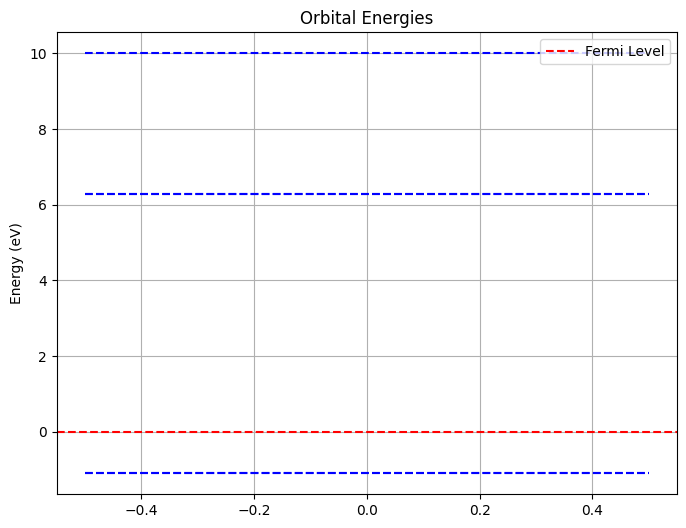

In [31]:
# # Diagonalize the Hamiltonian and overlap matrices
# eigenvalues, eigenvectors = eigh(H_lcao, S_lcao)
# # Calculate HOMO and LUMO energies, and gap
# homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_lcao, S_lcao,homo_index,lumo_index)
# print(f"HOMO energy: {homo_energy} eV")
# print(f"LUMO energy: {lumo_energy} eV")
# print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# # Plot orbital energies around the Fermi level
# plot_orbital_energies(H=H_lcao, S=S_lcao, fermi_level=0, n_valence=1, n_conduction=3)


# # Diagonalize the Hamiltonian and overlap matrices
# eigenvalues, eigenvectors = eigh(H_subdiagonal, S_subdiagonal)

# # Calculate HOMO and LUMO energies, and gap
# homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_subdiagonal,S_subdiagonal,homo_index,lumo_index)
# print(f"HOMO energy: {homo_energy} eV")
# print(f"LUMO energy: {lumo_energy} eV")
# print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# # Plot orbital energies around the Fermi level
# plot_orbital_energies(H=H_subdiagonal, S=S_subdiagonal, fermi_level=0, n_valence=1, n_conduction=3)

# # Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_active,S_active)

# Since the H_active has dimensions 26 X 26 and there are 2 electrons per state, 13 states are occupied and 13 are unoccupied.
lumo_index_active = int(np.shape(H_active)[0]/2)
homo_index_active = lumo_index_active - 1

# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_active,S_active,homo_index_active,lumo_index_active)
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_active, S=S_active, fermi_level=0, n_valence=1, n_conduction=3)
